In [2]:
# Third-party
import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import InterpolatedUnivariateSpline

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData
from sfd import reddening

In [3]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc, 
                                    z_sun=0*u.pc)

In [4]:
g = GaiaData('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')
g = g[(g.FE_H_FLAG == 0) & 
      (g.FE_H_ERR < 0.1) & (g.MG_FE_ERR < 0.1) &
      (g.FE_H > -2) & (g.FE_H < 0.5) &
      (g.MG_FE > -2) & (g.MG_FE < 2) &
      (g.LOGG < 3.5) & (g.LOGG > 0) &
      (g.parallax < 1*u.mas) & 
      (np.abs(g.VHELIO_AVG) < 400)]
len(g)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


156164

In [5]:
mean_tracks = np.load('../data/gal_mean_tracks.npy')
std_tracks = np.load('../data/gal_std_tracks.npy')

In [6]:
skyc = g.get_skycoord(distance=False)
skyc = skyc.galactic

In [7]:
EBV = g.get_ebv()
AJHK = reddening(skyc, '2MASS', ['J', 'H', 'Ks'], ebv=EBV)

J0 = g.J - AJHK[:, 0]
Ks0 = g.K - AJHK[:, 2]
JKs0 = J0 - Ks0

In [8]:
feh = g.FE_H
dist = 0.75 * coord.Distance(distmod=Ks0 - ((3.8 + 1.3*feh) - 8.4 * JKs0)).to(u.kpc)

dist_mask = ((dist > 5*u.kpc) & (dist < 25*u.kpc) &
             (skyc.l.degree > 60) & (skyc.l.degree < 300))
subg = g[dist_mask]
c = subg.get_skycoord(distance=dist[dist_mask],
                      radial_velocity=subg.VHELIO_AVG*u.km/u.s)
c = c.galactic
len(subg)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/coordinates/distances.py:133: RuntimeWarning: divide by zero encountered in log10
  meanlogval = np.log10(value.value).mean()


11993

In [33]:
mask = np.ones(len(c), dtype=bool)
for i, comp in zip([1, 3, 4, 5],
                   ['b', 'pm_l_cosb', 'pm_b', 'radial_velocity']):
    mean_spl = InterpolatedUnivariateSpline(mean_tracks[:, 0], mean_tracks[:, i])
    std_spl = InterpolatedUnivariateSpline(std_tracks[:, 0], std_tracks[:, i])

    mask &= np.abs(getattr(c, comp).value - mean_spl(c.l.degree)) < 4*std_spl(c.l.degree)
mask.sum()

1377

In [34]:
control_mask = np.ones(len(c), dtype=bool)
for i, comp in zip([1, 3, 4, 5],
                   ['b', 'pm_l_cosb', 'pm_b', 'radial_velocity']):
    if i == 1:
        mean_spl = InterpolatedUnivariateSpline(mean_tracks[:, 0], -mean_tracks[:, i])
    else:
        mean_spl = InterpolatedUnivariateSpline(mean_tracks[:, 0], mean_tracks[:, i])
    std_spl = InterpolatedUnivariateSpline(std_tracks[:, 0], std_tracks[:, i])

    control_mask &= np.abs(getattr(c, comp).value - mean_spl(c.l.degree)) < 4*std_spl(c.l.degree)
control_mask.sum()

1555

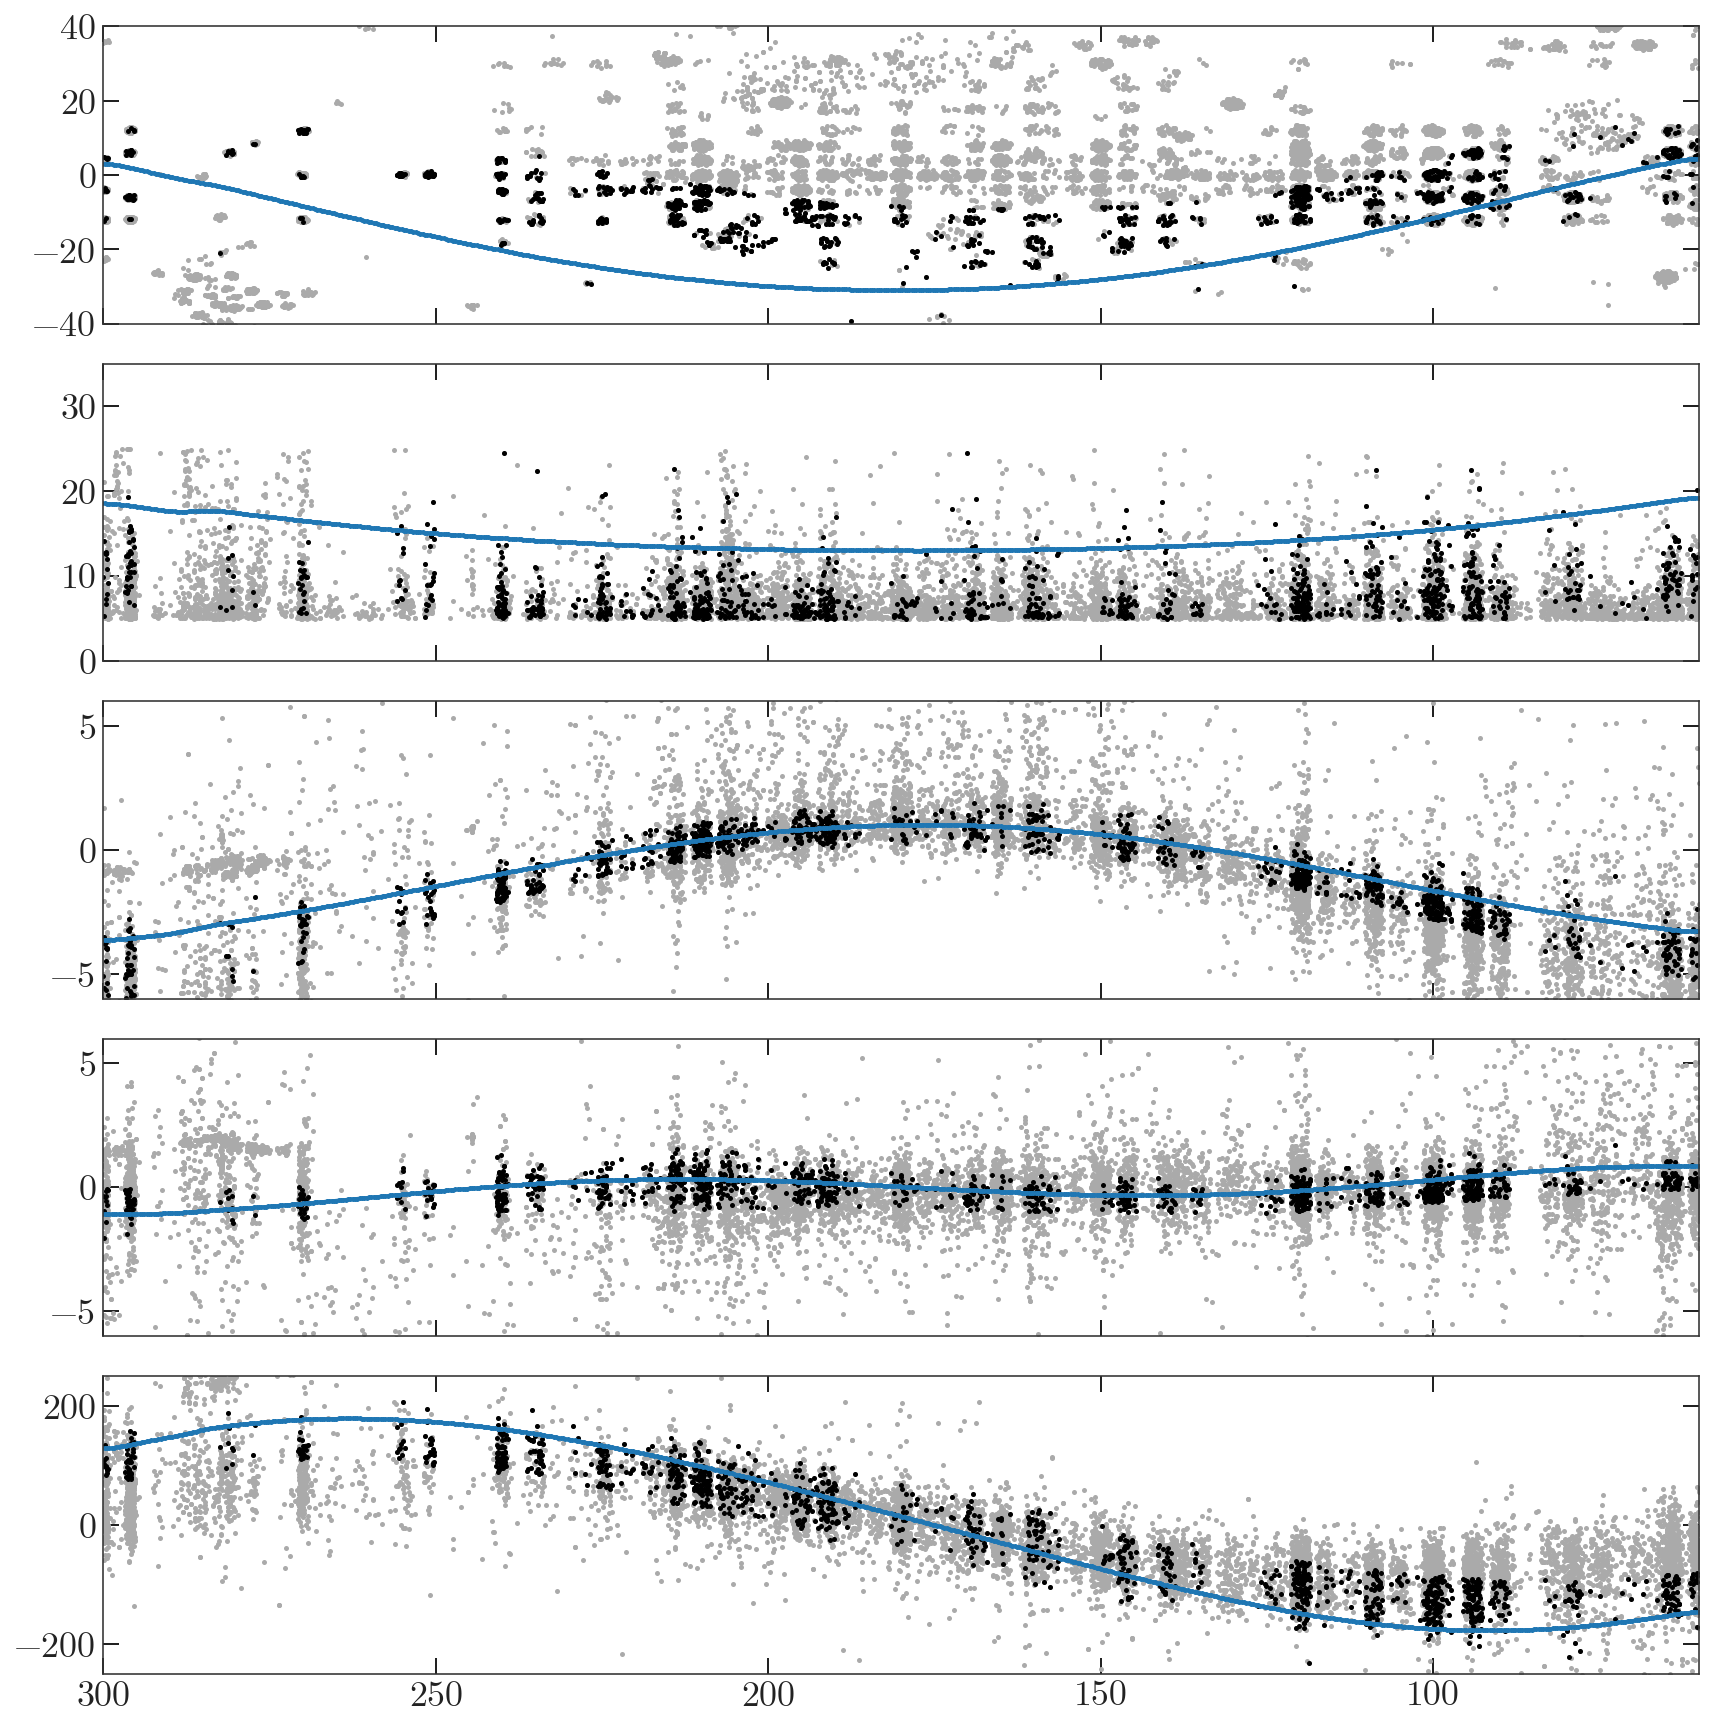

In [35]:
fig, axes = plt.subplots(5, 1, figsize=(12, 12),
                         sharex=True)
lims = [(-40, 40), (0, 35), (-6, 6), (-6, 6), (-250, 250)]
for i, comp in zip(range(1, 5+1),
                   ['b', 'distance', 'pm_l_cosb', 'pm_b', 'radial_velocity']):
    ax = axes[i-1]
    ax.plot(c.l.degree, 
            getattr(c, comp).value,
            marker='.', ls='none', color='#aaaaaa')
    ax.plot(c.l.degree[mask], 
            getattr(c, comp).value[mask],
            marker='.', ls='none', color='k')
    ax.set_ylim(lims[i-1])
    
    mean_spl = InterpolatedUnivariateSpline(mean_tracks[:, 0], mean_tracks[:, i])
    grid = np.linspace(0, 360, 1024)
    ax.plot(grid, mean_spl(grid))

ax.set_xlim(300, 60)

fig.tight_layout()

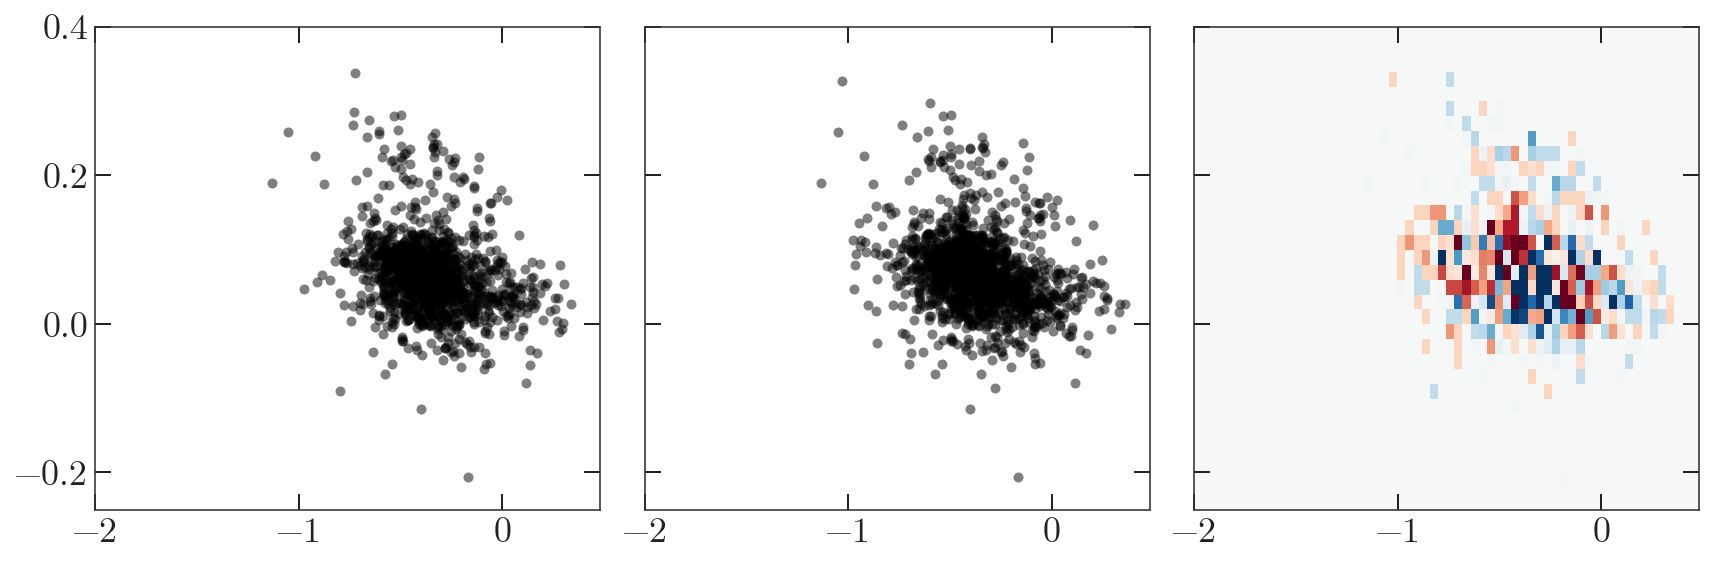

In [39]:
bins = (np.arange(-2, 0.5, 0.04),
        np.arange(-0.5, 1., 0.02))

H1, xe, ye = np.histogram2d(subg.FE_H[mask], subg.ALPHA_M[mask],
                            bins=bins)
H2, xe, ye = np.histogram2d(subg.FE_H[control_mask], subg.ALPHA_M[control_mask],
                            bins=bins)
f = (H1.sum() / H2.sum())

fig, axes = plt.subplots(1, 3, figsize=(12, 4),
                         sharex=True, sharey=True)
# axes[0].pcolormesh(xe, ye, H1.T)
# axes[1].pcolormesh(xe, ye, H2.T)
axes[0].plot(subg.FE_H[mask], subg.ALPHA_M[mask], 
             marker='o', ls='none', color='k', alpha=0.5)
axes[1].plot(subg.FE_H[control_mask], subg.ALPHA_M[control_mask], 
             marker='o', ls='none', color='k', alpha=0.5)
axes[2].pcolormesh(xe, ye, (H1 - f*H2).T,
                   cmap='RdBu', 
                   vmin=-4, vmax=4)

axes[0].set_ylim(-0.25, 0.4)

fig.tight_layout()